# SARIMAX
- The (extended) ARIMA family of methods is too big to be properly explained in this course.
    - At NMBU, the course DAT320 goes deeper and explains the data generating processes.
    - An online book with videos: [Forecasting: Principles and Practice](https://otexts.com/fpp3/).
- We therefore skip (almost) directly to the regression models (based on [phosgene89's GitHub page](https://phosgene89.github.io/sarima.html)) and their usage.
- But first we introduce a dataset and the concepts of stationarity and autocorrelation.

__Stationarity:__
- The distribution of the time series is independent of which part of the time series you look at.
    - Trends, seasonality (cycles of fixed width) and changes in variance lead to non-stationarity.
    - Differencing (first or second order discrete derivatives) can help.
        - Seasonal differencing means the difference is not between neighbours but higher lags.
- If the data is not stationary, pre-processing or modelling of the specific deviations from stationarity is needed.

## Wholesale price index (WPI) data
- We will illustrate some concepts and models using the WPI data.

In [1]:
# Imports
import numpy as np
import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt
from datetime import datetime
import requests
from io import BytesIO

# Load Wholesale price index (WPI) data
wpi1 = requests.get('https://www.stata-press.com/data/r12/wpi1.dta').content
data = pd.read_stata(BytesIO(wpi1))
data.index = data.t
data['ln_wpi'] = np.log(data['wpi'])
data['D.ln_wpi'] = data['ln_wpi'].diff()
# Set the frequency to Quarterly Start, year ending October
data.index.freq="QS-OCT"
data.head()

,wpi,t,ln_wpi,D.ln_wpi
t,,,,
1960-01-01,30.700001,1960-01-01,3.424263,NaN
1960-04-01,30.799999,1960-04-01,3.427515,0.003252
1960-07-01,30.700001,1960-07-01,3.424263,-0.003252
1960-10-01,30.700001,1960-10-01,3.424263,0.000000
1961-01-01,30.799999,1961-01-01,3.427515,0.003252


## Autocorrelation
- [Autocorrelation](https://en.wikipedia.org/wiki/Autocorrelation) is the correlation between a stationary timeseries and a lagged version of itself.
    - This is a measure of the time dependence in the series, i.e., lack of independence.
    - Can be used to indicate the appropriate lag in moving average (MA) models.
- [Partial autocorrelation](https://en.wikipedia.org/wiki/Partial_autocorrelation_function) is the autocorrelation when controlling for (regressed on) all intermediate time lags.
    - Can be used to indicate the appropriate lag in autogregressive (AR) models.

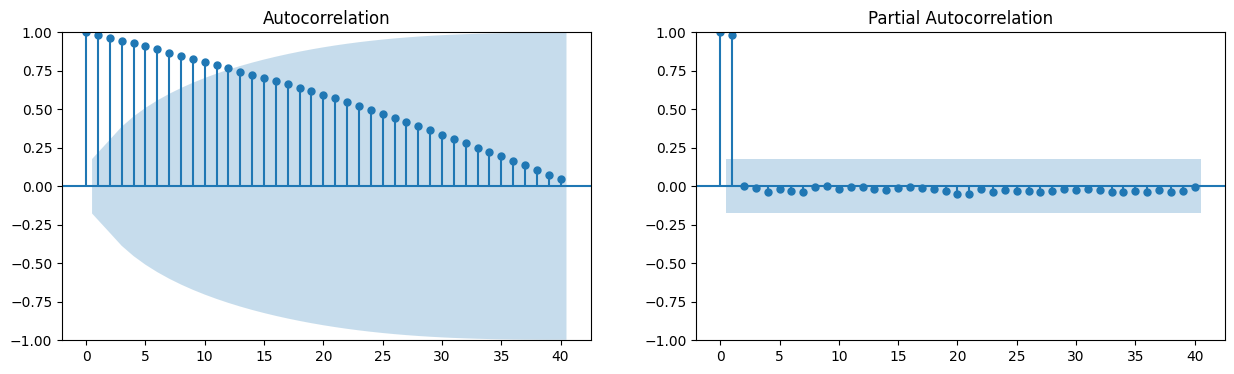

In [2]:
# Autocorrelation and partial autocorrelation plots (raw data)
fig, axes = plt.subplots(1, 2, figsize=(15,4))
fig = sm.graphics.tsa.plot_acf(data.iloc[1:]['wpi'], lags=40, ax=axes[0])
fig = sm.graphics.tsa.plot_pacf(data.iloc[1:]['wpi'], lags=40, ax=axes[1])

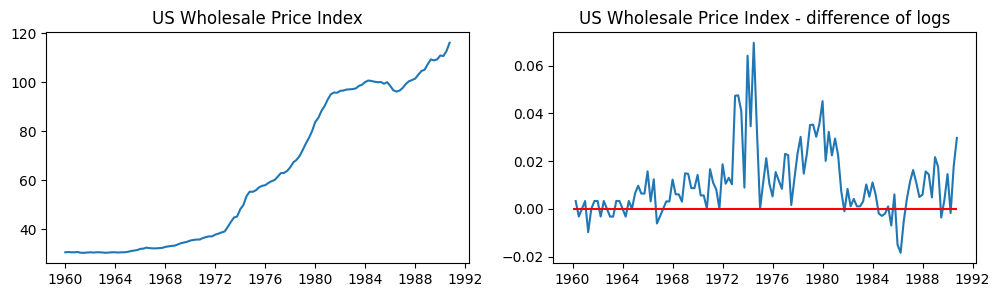

In [3]:
# Graph data
fig, axes = plt.subplots(1, 2, figsize=(12,3))

# Levels
axes[0].plot(data.index._mpl_repr(), data['wpi'], '-')
axes[0].set(title='US Wholesale Price Index')

# Log difference (attempting to improve stationarity)
axes[1].plot(data.index._mpl_repr(), data['D.ln_wpi'], '-')
axes[1].hlines(0, data.index[0], data.index[-1], 'r')
axes[1].set(title='US Wholesale Price Index - difference of logs');

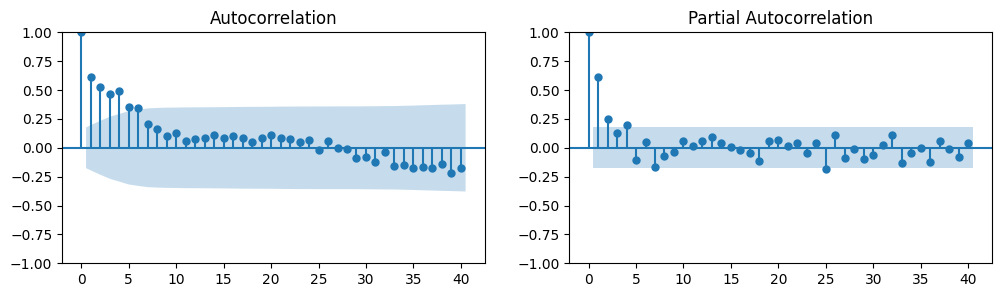

In [4]:
# Autocorrelation and partial autocorrelation plots 
# after applying the logarithm and differencing
fig, axes = plt.subplots(1, 2, figsize=(12,3))
fig = sm.graphics.tsa.plot_acf(data.iloc[1:]['D.ln_wpi'], lags=40, ax=axes[0])
fig = sm.graphics.tsa.plot_pacf(data.iloc[1:]['D.ln_wpi'], lags=40, ax=axes[1])

## Autoregressive models in Python
- Using the [_statsmodels_](https://www.statsmodels.org/dev/generated/statsmodels.tsa.statespace.sarimax.SARIMAX.html) package, the most complex model is the starting point.
- Setting the various parameters of $SARIMAX(p, d, q)(P, D, Q, s)$, we can obtain any of the below mentioned models.
    - SARIMAX(endog, exog=None, order=(1, 0, 0), seasonal_order=(0, 0, 0, 0), trend=None, ...)
- For integer values of $p/d/q/P/D/Q$, all lags up to the integer are included. For more fine-grained control, lists can be applied, e.g., [1,0,1] includes lags 1 and 3, but not 2.
- There are also various other parameters, e.g., a trend (none, constant, linear, quadratic, polynomial).

## AR - autoregressive models
- For a (single variable) timeseries given by $\{ y_{t} \}$, we can specify the $AR(p)$ model as:
  
$$ y_{t} = \beta + \sum\limits_{i=1}^p \theta_{i} y_{t-i} + \epsilon_{t}.$$
  
- Here, $\beta$ is a constant, $\theta_{i}$ is the coefficient for the $p$-th time lag and $\epsilon_{t}$ is the error. 
- Introducing a lag operator, $L^{n} y_{t} = y_{t-n}$, we can redefine the above equation in the form of a polynomial function, $\Theta(L)^{p}$ as:
  
$$ y_{t} = \Theta(L)^{p} y_{t} + \epsilon_{t},$$  
  
- i.e., the current time is a function of $p$ previous time points and a constant. This can be thought of as stacking subsets of a time series using a moving window and performing ordinary least squares on the resulting matrix/dataframe.

In [5]:
# Fit an AR(1) model (badly specified due to non-stationarity)
mod = sm.tsa.statespace.SARIMAX(data['wpi'], trend='c', order=(1,0,0)) # trend='c' adds a constant
res = mod.fit(disp=False)
print(res.summary()) # AIC gives us a measure of fit for comparison

                               SARIMAX Results                                
Dep. Variable:                    wpi   No. Observations:                  124
Model:               SARIMAX(1, 0, 0)   Log Likelihood                -201.927
Date:                Fri, 13 Sep 2024   AIC                            409.855
Time:                        15:48:20   BIC                            418.316
Sample:                    01-01-1960   HQIC                           413.292
                         - 10-01-1990                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0293      0.343      0.086      0.932      -0.643       0.701
ar.L1          0.9996      0.005    213.302      0.000       0.990       1.009
sigma2         1.4355      0.143     10.008      0.0

/Users/kristian/miniforge3/envs/IND320_2024/lib/python3.12/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'


## MA - moving average models
- MA models are functions of previous errors, rather than previous measurements. 
- We can define an $MA(q)$ model as:
  
$$ y_{t} = \Phi(L)^{q} \epsilon_{t} + \epsilon_{t}.$$
  
- Here, $q$ is the number of time lags and $\Phi(L)^{q}$ is defined as $\Theta$ above, but using the error terms and $\epsilon_{t}$ is with respect to the current model.

In [6]:
# Fit an MA(1) model (disregarding the obvious autocorrelation)
mod = sm.tsa.statespace.SARIMAX(data['wpi'], trend='c', order=(0,0,1))
res = mod.fit(disp=False)
print(res.summary()) # AIC gives us a measure of fit for comparison

                               SARIMAX Results                                
Dep. Variable:                    wpi   No. Observations:                  124
Model:               SARIMAX(0, 0, 1)   Log Likelihood                -516.522
Date:                Fri, 13 Sep 2024   AIC                           1039.044
Time:                        15:48:20   BIC                           1047.505
Sample:                    01-01-1960   HQIC                          1042.481
                         - 10-01-1990                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     62.8671      3.033     20.727      0.000      56.922      68.812
ma.L1          0.9994      0.578      1.728      0.084      -0.134       2.133
sigma2       233.8558    132.671      1.763      0.0

/Users/kristian/miniforge3/envs/IND320_2024/lib/python3.12/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


## ARMA - autoregressive moving average models
- When we take the sum of $AR(p)$ and $MA(q)$ models of the same time series, we get $ARMA(p,q)$ models:
  
$$ y_{t} = \Theta(L)^{p} y_{t} + \Phi(L)^{q} \epsilon_{t} + \epsilon_{t}$$
  
- Again, $\epsilon_{t}$ is with respect to the current model, but shares name with the previous models.
- This model is learning both from seeing previous samples and from how well these were predicted at previous time steps, thus it can tackle changes in the average.

In [7]:
# Fit an ARMA(1,1) model (badly specified due to non-stationarity)
mod = sm.tsa.statespace.SARIMAX(data['wpi'], trend='c', order=(1,0,1))
res = mod.fit(disp=False)
print(res.summary()) # AIC gives us a measure of fit for comparison

                               SARIMAX Results                                
Dep. Variable:                    wpi   No. Observations:                  124
Model:               SARIMAX(1, 0, 1)   Log Likelihood                -172.610
Date:                Fri, 13 Sep 2024   AIC                            353.221
Time:                        15:48:20   BIC                            364.502
Sample:                    01-01-1960   HQIC                           357.804
                         - 10-01-1990                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0438      0.427      0.103      0.918      -0.794       0.882
ar.L1          0.9994      0.006    172.091      0.000       0.988       1.011
ma.L1          0.5628      0.072      7.848      0.0

/Users/kristian/miniforge3/envs/IND320_2024/lib/python3.12/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'


## ARIMA - autoregressive integrated moving average models
- To help compensate for lack of stationarity, we add an integration operator, $\Delta^{d}$, defined as:
  
$$y_{t}^{[d]} =\Delta^{d} y_{t} = y_{t}^{[d-1]} - y_{t-1}^{[d-1]}.$$
  
- Here, $y_{t}^{[0]} = y_{t}$ and the degree of differensing is $d$.
- An $ARMA(p, q)$ model where $y_{t}$ is exchanged with $y_{t}^{[d]}$ would look like this:
  
$$ y_{t}^{[d]} = \Theta(L)^{p} y_{t}^{[d]} + \Phi(L)^{q} \epsilon_{t}^{[d]} + \epsilon_{t}^{[d]}$$
  
- Reformulating this using the integration operator, we get an $ARIMA(p,d,q)$ model:
  
$$ \Delta^{d} y_{t} = \Theta(L)^{p} \Delta^{d} y_{t} + \Phi(L)^{q} \Delta^{d} \epsilon_{t} + \Delta^{d} \epsilon_{t}$$
  
- Finally, it can be shown that this is euqivalent to:
  
$$ \Theta(L)^{p} \Delta^{d} y_{t} = \Phi(L)^{q} \Delta^{d} \epsilon_{t}$$
  
- This model has the properties of the ARMA model, but in addition does the differensing for us, meaning that predicitons will be on the original scale instead of predicting difference values.

In [8]:
# Fit an ARIMA(1,1,1) model
mod = sm.tsa.statespace.SARIMAX(data['wpi'], trend='c', order=(1,1,1))
res = mod.fit(disp=False)
print(res.summary()) # AIC gives us a measure of fit for comparison

                               SARIMAX Results                                
Dep. Variable:                    wpi   No. Observations:                  124
Model:               SARIMAX(1, 1, 1)   Log Likelihood                -135.351
Date:                Fri, 13 Sep 2024   AIC                            278.703
Time:                        15:48:20   BIC                            289.951
Sample:                    01-01-1960   HQIC                           283.272
                         - 10-01-1990                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0943      0.068      1.389      0.165      -0.039       0.227
ar.L1          0.8742      0.055     16.028      0.000       0.767       0.981
ma.L1         -0.4120      0.100     -4.119      0.0

In [9]:
# Since the data are quarterly, we can add a seasonal component by including a fourth time lag to moving average
# Fit an ARIMA(1,1,[1,0,0,1]) model
mod = sm.tsa.statespace.SARIMAX(data['wpi'], trend='c', order=(1,1,[1,0,0,1]))
res = mod.fit(disp=False)
print(res.summary()) # AIC gives us a measure of fit for comparison
# What about a linear trend? (trend='t')

                                 SARIMAX Results                                 
Dep. Variable:                       wpi   No. Observations:                  124
Model:             SARIMAX(1, 1, [1, 4])   Log Likelihood                -135.066
Date:                   Fri, 13 Sep 2024   AIC                            280.132
Time:                           15:48:20   BIC                            294.193
Sample:                       01-01-1960   HQIC                           285.843
                            - 10-01-1990                                         
Covariance Type:                     opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.1260      0.092      1.370      0.171      -0.054       0.306
ar.L1          0.8325      0.081     10.231      0.000       0.673       0.992
ma.L1         -0.3710      0

## SARIMA - seasonal autoregressive integrated moving average models
- SARIMA shares some resemblance with the STL decomposition introduced previously.
- For seasons of length $s$, the seasonal part is obtained by applying an ARIMA model with lags, $P$ and $Q$, and integration time, $D$, that are multiples of $s$, i.e., if $P=2$, the included time points would be $t-1s$ and $t-2s$.
  
$$ \Delta_{s}^{D} y_{t} = \theta(L^{s})^{P} \Delta_{s}^{D} y_{t} + \phi(L^{s})^{Q} \Delta_{s}^{D} \epsilon_{t} + \Delta_{s}^{D} \epsilon_{t} $$

- Like the ARIMA model, this can be shown to be equivalent to:
  
$$ \theta(L^{s})^{P} \Delta_{s}^{D} y_{t} =  \phi(L^{s})^{Q} \Delta_{s}^{D} \epsilon_{t} $$
  
- After the seasonal part has been removed, another $ARIMA(p, d, q)$ applied to $\Delta_{s}^{D} y_{t}$ is equivalent to multiplying the two models together.
- The $SARIMA(p, d, q)(P, D, Q, s)$ model then becomes:
  
$$ \Theta(L)^{p} \theta(L^{s})^{P} \Delta^{d} \Delta_{s}^{D} y_{t} = \Phi(L)^{q} \phi(L^{s})^{Q} \Delta^{d} \Delta_{s}^{D} \epsilon_{t}$$
  
- This model has the ability to combine experience from previous timepoints with seasonal trends. 
    - Or if one sets the ARIMA parameters $p=0$, $d=0$, $q=0$, one can have a pure seasonal model.

In [10]:
# Using SARIMA for seasonality instead of the fourth time lag to moving average.
# Fit a SARIMA(1,1,1)(1,1,1,4) model
mod = sm.tsa.statespace.SARIMAX(data['wpi'], trend='c', order=(1,1,1), seasonal_order=(1,1,1,4))
res = mod.fit(disp=False)
print(res.summary()) # AIC gives us a measure of fit for comparison (no improvement here)

                                     SARIMAX Results                                     
Dep. Variable:                               wpi   No. Observations:                  124
Model:             SARIMAX(1, 1, 1)x(1, 1, 1, 4)   Log Likelihood                -134.632
Date:                           Fri, 13 Sep 2024   AIC                            281.264
Time:                                   15:48:20   BIC                            297.939
Sample:                               01-01-1960   HQIC                           288.035
                                    - 10-01-1990                                         
Covariance Type:                             opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0071      0.004      1.680      0.093      -0.001       0.015
ar.L1          0.8330      0.073     11.377

/Users/kristian/miniforge3/envs/IND320_2024/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


## Exogenous variables
- As we showed in the previous chapter, it is possible to make a model purely on other variables measured at the same time, $t$.
- Including these variables into ARIMA and SARIMA, we get the ARIMAX and SARIMAX models.
- In practice, we paste on an extra coefficient vector, $\beta$, and variables, $X_{t}$, to he models, here noted as sums of products $\beta_{i} x^{i}_{t}$: 
- $ARIMAX(p, d, q)$:
  
$$\Theta(L)^{p} \Delta^{d} y_{t} = \Phi(L)^{q} \Delta^{d} \epsilon_{t} + \sum_{i=1}^{n} \beta_{i} x^{i}_{t}$$
  
- $SARIMAX(p, d, q)(P, D, Q, s)$:
  
$$\Theta(L)^{p} \theta(L^{s})^{P} \Delta^{d} \Delta_{s}^{D} y_{t} = \Phi(L)^{q} \phi(L^{s})^{Q} \Delta^{d} \Delta_{s}^{D} \epsilon_{t} + \sum_{i=1}^{n} \beta_{i} x^{i}_{t}$$
  
- The final model, thus includes autogression and moving averages, can perform differences, deals with seasonality and can leverage external variables from the same timepoint as the predictions.

In [11]:
# Read the FinalData sheet of the OilExchange.xlsx file using Pandas again
import pandas as pd
OilExchange = pd.read_excel('../../data/OilExchange.xlsx', sheet_name='FinalData')
OilExchange.index = OilExchange.Date
OilExchange.index.freq = "MS" # Set the frequency to Month Start
OilExchange.head()

# Fit a SARIMAX(1,1,1)(1,1,1,12) model with exogenous variables (closing our eyes, as we know little about the data)
mod = sm.tsa.statespace.SARIMAX(OilExchange['PerEURO'], #OilExchange.loc[:, OilExchange.columns[3:-4]], \
                                trend='c', order=(4,1,4), seasonal_order=(1,1,1,12))
#mod = sm.tsa.statespace.SARIMAX(OilExchange['PerEURO'], OilExchange.loc[:, OilExchange.columns[3:-4]], \
#                                trend='c', order=(1,1,1), seasonal_order=(1,1,1,12))
res = mod.fit(disp=False)
print(res.summary()) # AIC gives us a measure of fit for comparison (no improvement here)

/Users/kristian/miniforge3/envs/IND320_2024/lib/python3.12/site-packages/openpyxl/worksheet/_reader.py:329: UserWarning: Unknown extension is not supported and will be removed
  warn(msg)


                                      SARIMAX Results                                       
Dep. Variable:                              PerEURO   No. Observations:                  179
Model:             SARIMAX(4, 1, 4)x(1, 1, [1], 12)   Log Likelihood                 107.744
Date:                              Fri, 13 Sep 2024   AIC                           -191.488
Time:                                      15:48:21   BIC                           -154.145
Sample:                                  01-01-2000   HQIC                          -176.330
                                       - 11-01-2014                                         
Covariance Type:                                opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0041      0.009      0.461      0.645      -0.013       0.021
ar.L1         -0.42

/Users/kristian/miniforge3/envs/IND320_2024/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


## Exercise
- Play with the OilExchange data.
- See if you can improve the fit of the model by adjusting lags and removing the least significant terms in the model.

## SARIMAX prediction
- One-step-ahead prediction uses the estimated parameters and samples within the lags of the model to predict the next time point.
    - This means that the predictions will stay relatively close to the true values, never predicting more than one step away from the truth.
- Dynamic prediction predicts one step as above, then uses predicted values as input instead of true values.
    - This means the predictions can deviate from the truth over time.

In [12]:
# Refit the model on the training set (up to 2013-01-01)
mod = sm.tsa.statespace.SARIMAX(OilExchange['PerEURO'].loc[:'2013-01-01'], \
                                OilExchange.loc[:, OilExchange.columns[3:-4]].loc[:'2013-01-01'], \
    trend='c', order=(1,1,1), seasonal_order=(1,1,1,12))
res = mod.fit(disp=False)

/Users/kristian/miniforge3/envs/IND320_2024/lib/python3.12/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Users/kristian/miniforge3/envs/IND320_2024/lib/python3.12/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


/Users/kristian/miniforge3/envs/IND320_2024/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [13]:
# Get predictions for the whole dataset
mod = sm.tsa.statespace.SARIMAX(OilExchange['PerEURO'], OilExchange.loc[:, OilExchange.columns[3:-4]], \
    trend='c', order=(1,1,1), seasonal_order=(1,1,1,12))
res = mod.filter(res.params) # One-stpe-ahead predictions

In [14]:
# In-sample one-step-ahead prediction wrapper function
predict = res.get_prediction()
predict_ci = predict.conf_int()

In [15]:
# Dynamic predictions starting from 2013-01-01
predict_dy = res.get_prediction(dynamic='2013-01-01')
predict_dy_ci = predict_dy.conf_int()

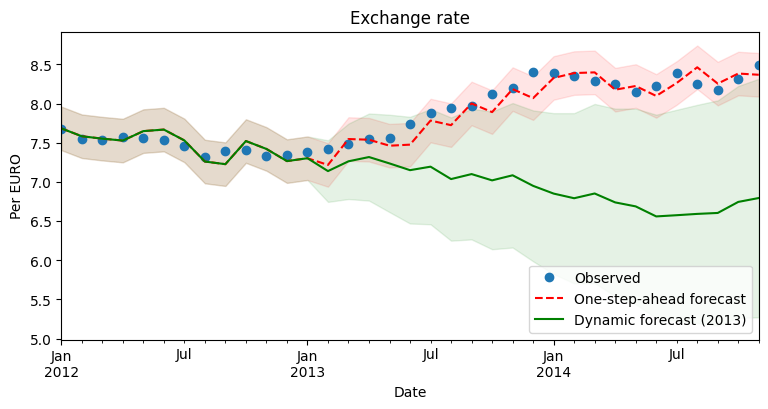

In [16]:
# Compare the one-step-ahead predictions to the dynamic predictions
fig, ax = plt.subplots(figsize=(9,4))
npre = 4
ax.set(title='Exchange rate', xlabel='Date', ylabel='Per EURO')

# Plot data points
OilExchange.loc['2012-01-01':, 'PerEURO'].plot(ax=ax, style='o', label='Observed')

# Plot predictions
predict.predicted_mean.loc['2012-01-01':].plot(ax=ax, style='r--', label='One-step-ahead forecast')
ci = predict_ci.loc['2012-01-01':]
ax.fill_between(ci.index, ci.iloc[:,0], ci.iloc[:,1], color='r', alpha=0.1)
predict_dy.predicted_mean.loc['2012-01-01':].plot(ax=ax, style='g', label='Dynamic forecast (2013)')
ci = predict_dy_ci.loc['2012-01-01':]
ax.fill_between(ci.index, ci.iloc[:,0], ci.iloc[:,1], color='g', alpha=0.1)

legend = ax.legend(loc='lower right')

## Questercise
- Does the model made in the previous exercise improve the predictions as visualized above?

```{seealso} Resources
:class: tip
- [Book and video lectures on Forecasting: Principles and Practice](https://otexts.com/fpp3/)
- [Wikipedia: Autocorrelation](https://en.wikipedia.org/wiki/Autocorrelation)
- [Wikipedia: Partial autocorrelation](https://en.wikipedia.org/wiki/Partial_autocorrelation_function)
- [phosgene89's GitHub page on SARIMAX](https://phosgene89.github.io/sarima.html)
- [statsmodels' SARIMAX documentation](https://www.statsmodels.org/dev/generated/statsmodels.tsa.statespace.sarimax.SARIMAX.html)
- [statsmodels' SARIMAX example](https://www.statsmodels.org/stable/examples/notebooks/generated/statespace_sarimax_stata.html)
```